**Implement an impedance control on a massage robot so that the robot can impose the appropriate dynamic interaction on the human body receiving the massage service. In the preliminary stage, the end-effector of the massage robot moves right over the planned contact point of human back, and the distance between the end-effector and human back is kept as 10 mm. 
When therapy starts, the end-effector of the massage robot moves right up and down periodically to press and release the contact point of human back repeatedly. The desired steady-state pressure imposed on the human back is set as 200 N. If the stiffness of human back Ke is assumed as 10 N/mm, then the depth of press is expected to reach 20 mm down from the rest position of human back xe when no contact occurs.**

If the initial height of the end-effector of massage robot is marked as 0 mm, then the desired steady-state position should be set at –30 mm upon the previous analysis in “Design Target” section. 
Thus the steady-state virtual position on virtual trajectory could be set slightly lower at –35 mm.

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
class MassSpringDamper:
    
    def __init__(self, mass, stiffness, damping, deadband = 0, dt = 0.001):
        self.mass = mass
        self.stiffness = stiffness
        self.damping = damping
        self.deadband = deadband
        self.dt = dt
        self.ddx = 0
        self.dx = 0
        self.x = 0
    
    def response(self, contact_force):
        x_new = self.x + self.dx*self.dt
        if abs(x_new) > self.deadband:
            dx_new = self.dx + (-self.stiffness*self.x -self.damping*self.dx + contact_force)/self.mass*self.dt
        else:
            dx_new = self.dx + contact_force/self.mass*self.dt
        self.x = x_new
        self.dx = dx_new
        return self.x, self.dx, self.stiffness
    
    def response_of_profile(self, contact_force_profile):
        return np.array([self.response(f) for f in contact_force_profile])

In [4]:
class Environment(MassSpringDamper):
    
    def __init__(self, mass, stiffness, damping, deadband):
        super().__init__(mass, stiffness, damping, deadband) 
        self.itr = 0
    
    def new_itr(self):
        self.itr += 1
        if self.itr > 1:
            self.stiffness = 20
        if self.itr > 2:
            self.deadband = 5
#         self.stiffness = max(self.stiffness-2, 3)
    
    def response_of_profile(self, contact_force_profile):
        self.new_itr()
        return super().response_of_profile(contact_force_profile)

In [5]:
class Robot(MassSpringDamper):
    
    def __init__(self, mass, stiffness, damping, deadband):
        super().__init__(mass, stiffness, damping, deadband)

## Substituting values

In [6]:
dt = 0.001
ramp_time = 3
steady_time = 5
break_time = 2
ramp_N = int(ramp_time/dt)
break_N = int(break_time/dt)
steady_N = int(steady_time/dt)

max_force = 100
max_displacement = -30

force_profile_ramp = np.linspace(0, max_force, ramp_N)
desired_force_profile = np.hstack([np.zeros(break_N), force_profile_ramp, np.ones(steady_N)*max_force, np.flip(force_profile_ramp), np.zeros(break_N)])

position_profile_ramp = np.linspace(0, max_displacement, ramp_N)
desired_position_profile = np.hstack([np.zeros(break_N), position_profile_ramp, np.ones(steady_N)*max_displacement, np.flip(position_profile_ramp), np.zeros(break_N)]) 

Text(0, 0.5, 'force (N)')

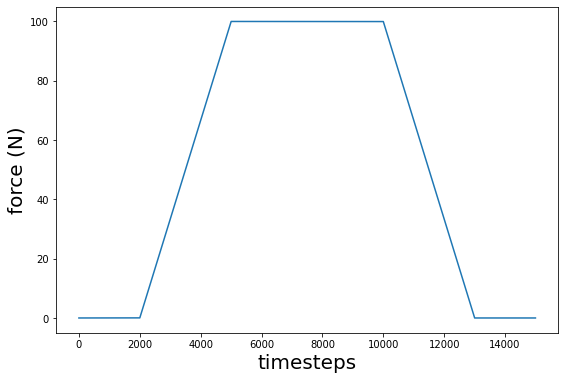

In [7]:
plt.figure(figsize=(9,6))
plt.plot(desired_force_profile)
plt.xlabel("timesteps", fontsize=20)
plt.ylabel("force (N)", fontsize=20)

Text(0, 0.5, 'displacement (mm)')

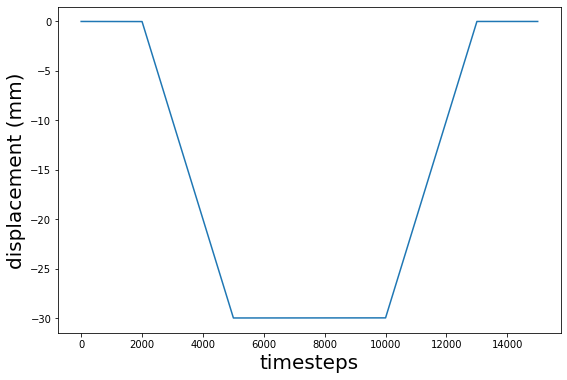

In [8]:
plt.figure(figsize=(9,6))
plt.plot(desired_position_profile)
plt.xlabel("timesteps", fontsize=20)
plt.ylabel("displacement (mm)", fontsize=20)

In [15]:
env = Environment(1, 12, 0, 10)

In [16]:
response = None
desired_force_profile_stack = desired_force_profile
desired_position_profile_stack = desired_position_profile
for i in range(3):
    if response is None:
        response = env.response_of_profile(desired_force_profile)
    else:
        response = np.vstack([response, env.response_of_profile(desired_force_profile)])
        desired_force_profile_stack = np.hstack([desired_force_profile_stack, desired_force_profile])
        desired_position_profile_stack = np.hstack([desired_position_profile_stack, desired_position_profile])

Text(0.5, 0, 'timesteps')

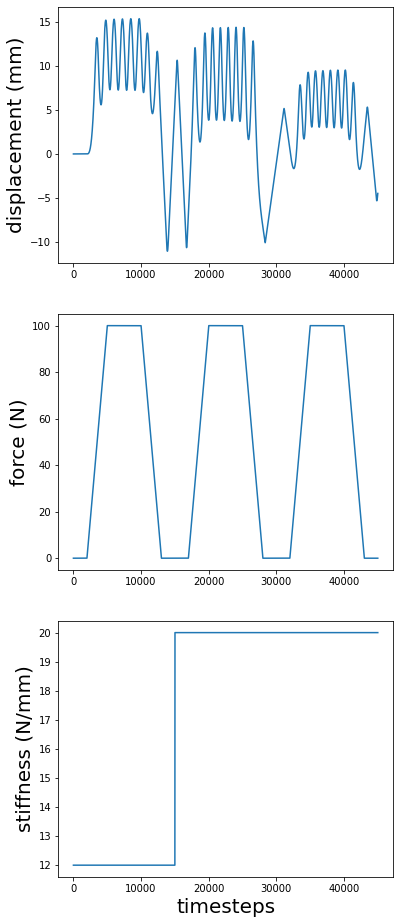

In [17]:
plt.figure(figsize=(6,16))
plt.subplot(3,1,1)
plt.plot(response[:, 0])
plt.ylabel("displacement (mm)", fontsize=20)
plt.subplot(3,1,2)
plt.plot(desired_force_profile_stack)
plt.ylabel("force (N)", fontsize=20)
plt.subplot(3,1,3)
plt.plot(response[:, 2])
plt.ylabel("stiffness (N/mm)", fontsize=20)
plt.xlabel("timesteps", fontsize=20)

## Control

$Kd = \frac{F_d K_e}{K_e (x_e - x_v) - F_d}$

substituting known values to the above equation, 

$F_d = 200N$

$K_e = 10N/mm$

$x_e = -10mm$

$x_d = -30mm$

$x_v \sim -35mm$

In [47]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [48]:
Md_slider = widgets.FloatSlider(
    value=2.,
    min=1.,
    max=100.0,
    step=0.1,
    description='Md:',
    readout_format='.1f',
)
Bd_slider = widgets.FloatSlider(
    value=2.,
    min=1.,
    max=100.0,
    step=0.1,
    description='Bd:',
    readout_format='.1f',
)
Kd_slider = widgets.FloatSlider(
    value=2.,
    min=1.,
    max=100.0,
    step=0.1,
    description='Kd:',
    readout_format='.1f',
)
generate = widgets.Button(
    value=False,
    description='Generate',
    icon='check'
)

In [49]:
def on_button_clicked(change):
    Md = Md_slider.get_state()['value']
    Kd = Kd_slider.get_state()['value']
    Bd = Bd_slider.get_state()['value']
    robot = Robot(Md, Kd, Bd, 0)
    
    robot_profile = robot.response_of_profile(desired_force_profile_stack)
    plt.figure(figsize=(9,6))
    plt.plot(robot_profile[:, 0])
    plt.xlabel("timesteps", fontsize=20)
    plt.ylabel("force (N)", fontsize=20)
    plt.title("Robot response", fontsize=20)
    
    plt.figure(figsize=(9,6))
    plt.plot(desired_position_profile_stack)
    plt.xlabel("timesteps", fontsize=20)
    plt.ylabel("displacement (mm)", fontsize=20)
    plt.title("Virtual trajectory", fontsize=20)
    
    x_hat = desired_position_profile_stack + robot_profile[:, 0]
    plt.figure(figsize=(12,9))
    plt.plot(x_hat, 'g', label='actual_trajectory')
    plt.plot(desired_position_profile_stack, 'r', label='desired_trajectory')
    plt.xlabel("timesteps", fontsize=20)
    plt.ylabel("displacement (mm)", fontsize=20)
    plt.legend()
    plt.title("Actual trajectory", fontsize=20)
    
    plt.show()

generate.on_click(on_button_clicked)

In [50]:
Md_slider

FloatSlider(value=2.0, description='Md:', min=1.0, readout_format='.1f')

In [51]:
Kd_slider

FloatSlider(value=2.0, description='Kd:', min=1.0, readout_format='.1f')

In [52]:
Bd_slider

FloatSlider(value=2.0, description='Bd:', min=1.0, readout_format='.1f')

Button(description='Generate', icon='check', style=ButtonStyle())

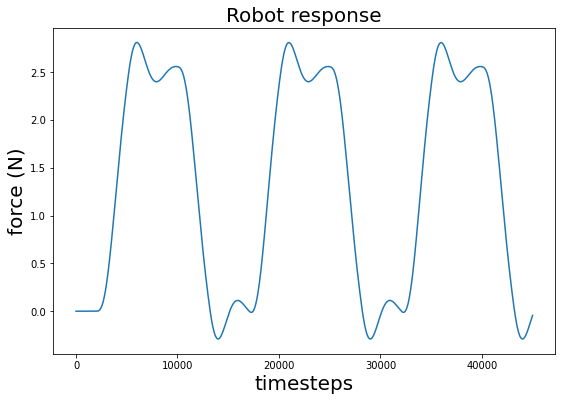

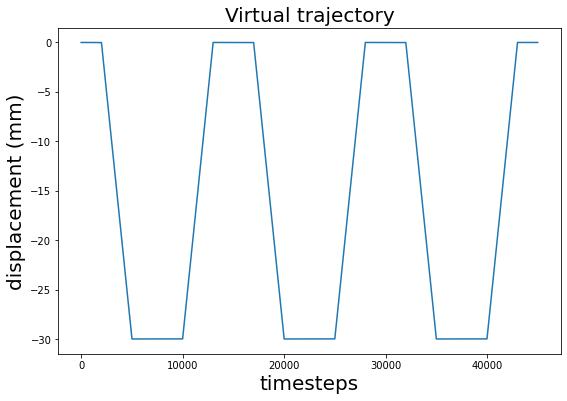

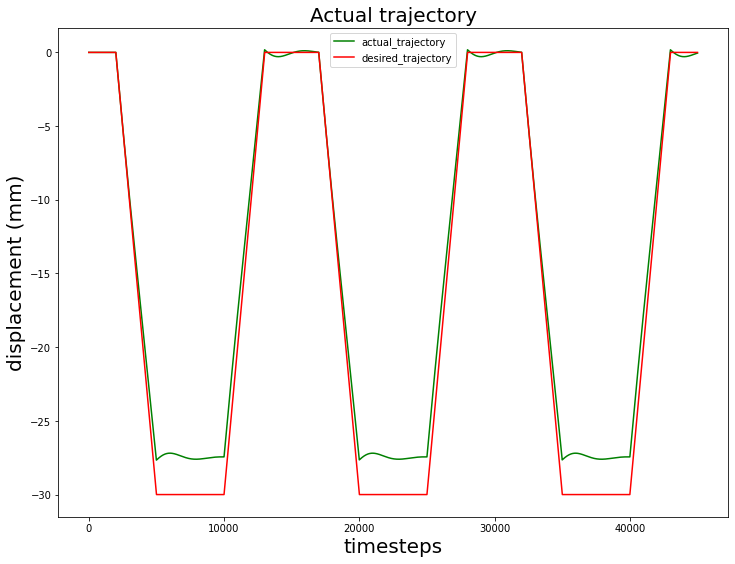

In [53]:
generate